# P3 - Wrangle OpenStreetMap Data
***by Bruno de Assis Pereira***

---
In this project, I am going to present a process of **data wrangling** over a dataset extracted from the ***OpenStreetMap***. In this case, I have selected the map from **Curitiba**, one of Brazil's capitals, and I am going to apply different techniquics for analysing, cleaning and standardizing this data so I can finally load into a **MongoDB** database and develop some queries over the final dataset.

Let's start!

#### Initializing libraries and globals

In [2]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint
import codecs
import json
import os
from pymongo import MongoClient

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

OSMFILE = "Curitiba.osm"

file_size = os.stat(OSMFILE).st_size
"File Size: %.2f MB"%(file_size/1000000.0)

'File Size: 66.65 MB'

#### Analyzing Tags within the Dataset

In [3]:
def count_tags(filename):
    dict_ret = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag in dict_ret.keys():
            dict_ret[elem.tag] += 1
        else :
            dict_ret[elem.tag] = 1
    
    return dict_ret

def test():

    tags = count_tags(OSMFILE)
    pprint.pprint(tags)
    
if __name__ == "__main__":
    test()

{'bounds': 1,
 'member': 6957,
 'nd': 371292,
 'node': 282662,
 'osm': 1,
 'relation': 1191,
 'tag': 159749,
 'way': 51402}


In [4]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        cur_key = element.attrib['k']
        if lower.search(cur_key):
            keys['lower'] += 1
        elif lower_colon.search(cur_key):
            keys['lower_colon'] += 1
        elif problemchars.search(cur_key):
            keys['problemchars'] += 1
        else:
            keys['other'] += 1
        
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

def test():
    keys = process_map(OSMFILE)
    pprint.pprint(keys)


if __name__ == "__main__":
    test()

{'lower': 145661, 'lower_colon': 13307, 'other': 781, 'problemchars': 0}


#### How many users had interacted with this dataset?
To understand or at least have some idea of how this dataset can have different kinds of input, we could take a look at how many users had interacted with these data. From this analysis, we can see how many different points of view were applied over these data.

In [5]:
users = set()
for _, element in ET.iterparse(OSMFILE):
    if element.attrib.get('user') is not None:
        users.add(element.attrib['user'])

print "Users set size: %i\n" % len(users)
pprint.pprint(users)

Users set size: 556

set(['4b696d',
     'ANMurata',
     'ANTONIO MAGALHAES',
     'Adam Foerster',
     'Ademar Junior',
     'AlNo',
     'AlbertoPitol',
     'AleLopes',
     'Aleks-Berlin',
     'Alexandre Possebom',
     'Alexandre Queiroz de Almeida',
     'Alexandre de Menezes',
     'Alisson Fulgencio Fondazzi',
     'Altevir Baptista',
     'Amanda Leal',
     u'Ana Z\xf6lfeld',
     'Anderson Pires',
     'Andi Muraro',
     'AndrewBuck',
     u'Andr\xe9 Alvarenga',
     u'Andr\xe9 Avila',
     u'Andr\xe9 Felipe Arcanjo de Olivera',
     u'Andr\xe9 Urbano',
     'Araym',
     'Arkeronte',
     'Arnd Sbnk',
     'Arrivatrade',
     'Artfloriani',
     'Arthur Zac',
     'Baruio',
     'Basstoelpel',
     'Beerforfree',
     'Bergson Konig',
     'BetyPE',
     'Bilkow',
     'BladeTC',
     'Bobby-Fischer',
     'Bruna Lopes',
     'Bruno Grenier',
     'Bruno Ritter',
     'BuganiniQ',
     'CDaniel',
     'Caetano Andre',
     'Caio Silva (outrocaio)',
     'Carlos Augusto 

#### Analyzing keys for selection
With this analysis, I will be able to understand a little bit more about the information that is available in the dataset. From the result of the script below, I will select some of the classes and audit this data. 

In [6]:
keys = set()
for _, elem in ET.iterparse(OSMFILE):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            keys.add(tag.attrib['k'])

pprint.pprint(keys)

set(['2014worldcup',
     'Bruna',
     'IBGE:CD_ADMINIS',
     'IBGE:GEOCODIGO',
     'abandoned',
     'access',
     'addr:city',
     'addr:country',
     'addr:floor',
     'addr:housename',
     'addr:housenumber',
     'addr:inclusion',
     'addr:interpolation',
     'addr:number',
     'addr:place',
     'addr:postcode',
     'addr:state',
     'addr:street',
     'addr:suburb',
     'admin_level',
     'aeroway',
     'alt_name',
     'alt_name:it',
     'amenity',
     'amenity_1',
     'area',
     'area:highway',
     'artist_name',
     'artwork_subject',
     'artwork_type',
     'atm',
     'backrest',
     'barri',
     'barrier',
     'beauty',
     'bench',
     'bicycle',
     'bicycle_parking',
     'bin',
     'boat',
     'boundary',
     'brand',
     'bridge',
     'bridge:structure',
     'building',
     'building:colour',
     'building:levels',
     'building:levels:aboveground',
     'building:material',
     'building:min_level',
     'building:part',
   

From the list above, I have selected some items to interact with:
- addr:city
- addr:street
- addr:state
- addr:postcode
- recycling
- opening_hours

Besides that, I will also add information to each of my elements related to **creation** of the registry and **position** in latitude and longitude of the specified element.

#### Functions for Cleaning and Standardizing the Dataset
The dataset that I am dealing with presents lots of data without a defined standard. This can turn into a bigger problem once we start to extract statistics from these data since it can be misleading.
**Cleaning and Standardizing** this data will provide a more reliable information in the end.

In [7]:
# -- Regular Expressions -- #
street_type_re = re.compile(r'^\S+\.?\b', re.IGNORECASE)
postal_code_re = re.compile(r'^[0-9]{2}.[0-9]{3}-[0-9]{3}$')
letters_re = re.compile(r'[a-zA-Z]')
as_re = re.compile(ur'\ba\b|\bas\b|\bàs\b', re.UNICODE)
hours_re = re.compile(r'[0-9]{1,2}:[0-9]{1,2} ?- ?[0-9]{1,2}:[0-9]{1,2}')
week_interval_re = re.compile(ur'[A-Za-z]+ ?- ?[A-Za-z]+')
weekday_re = re.compile(ur'[A-Za-z]{3}')
split_re = re.compile(r'; [A-Za-z]{3}|, [A-Za-z]{3}|;[A-Za-z]{3}')
# ------------------------- #

expected_street_types = ["Rua", "Avenida", "Travessa", "Alameda", "Estrada", u"Praça", "Rodovia"]

# -- Mapping between values found and expected values -- #
street_types_mapping = { "rua": "Rua",
            "RUA": "Rua",
            "R" : "Rua",
            "R." : "Rua",
            "Av" : "Avenida",
            "Av." : "Avenida"
            }

cities_mapping = { "Curiiba": "Curitiba",
            "Curitba": "Curitiba",
            "Curitiba - PR": "Curitiba",
            "curitiba": "Curitiba",
            "Araucaria": "Araucária",
            "Sao José dos Pinhais": "São José dos Pinhais",
            "São José dos Pinhais - PR": "São José dos Pinhais",
            "São José dos Pinias": "São José dos Pinhais",
            "são José dos Pinhais": "São José dos Pinhais"
            }

weekdays_mapping = { "Mo" : "Mon",
            "mo" : "Mon",
            "Seg" : "Mon",
            "segunda" : "Mon",
            "Tuesday" : "Tue",
            "Tu" : "Tue",            
            "Ter" : "Tue",
            "We" : "Wed",
            "Th" : "Thu",
            "Fr" : "Fri",
            "fr" : "Fri",
            "sexta" : "Fri",
            "Sex" : "Fri",
            "sábado" : "Sat",
            "Sab" : "Sat",
            "Sa" : "Sat",
            "sa" : "Sat",
            "Sunday" : "Sun",
            "Su" : "Sun",
            "Dom" : "Sun"
}
# ------------------------------------------------------ #

weekdays_code_mapping = { "Mon" : 1,
            "Tue" : 2,
            "Wed" : 3,
            "Thu" : 4,
            "Fri" : 5,
            "Sat" : 6,
            "Sun" : 7          
}

#function to standardize the street types
def audit_street_type(street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected_street_types:
            return street_name
    return None

#function to standardize 'postal_code'
def audit_postal_code(postal_code):
    m = postal_code_re.search(postal_code)
    if m is None:
        if '-' in postal_code:
            postal_code = postal_code[:2]+'.'+postal_code[2:]
        else:
            postal_code = postal_code[:2]+'.'+postal_code[2:5]+'-'+postal_code[5:]
    
    if len(postal_code) != 10:
        postal_code = None
    
    return postal_code

#function to update fields according to the selected type (t - 'c': Cities | 's': Street | 'w': Weekday)
def update_name(name, mapping, t):
    if t == 'c':
        for key in mapping.keys():
            if name == key.decode('utf-8'):
                name = mapping[key]
    elif t == 's':
        for key in mapping.keys():
            if re.search(r'^'+key+' ',name):
                name = name.replace(key, mapping[key])
                name = name.replace('.','')
    elif t == 'w':
        for key in mapping.keys():
            dkey = key.decode('utf-8')
            weekday_re = re.compile(ur' '+dkey+' |'+dkey+' |'+dkey+'-|-'+dkey+' |'+dkey+'$|'+dkey+':|'+dkey+',', re.UNICODE)
            if weekday_re.search(name):
                name = name.replace(key.decode('utf-8'), mapping[key])
                
    return name

def week_mapping(week):
    for key in week_intervals_mapping.keys():
        if week == key:
            return week_intervals_mapping[key]

#function to verify if the current 'week_day' is within the 'week_interval'
def week_availability(week_interval, week_day):
    if len(week_interval) == 1:
        if week_interval[0] in weekdays_code_mapping.keys() and weekdays_code_mapping[week_interval[0]] == week_day:
            return True
    if len(week_interval) == 2:
        wk_code_1 = weekdays_code_mapping[week_interval[0].strip(' ')]
        wk_code_2 = weekdays_code_mapping[week_interval[1].strip(' ')]
        if wk_code_1 > wk_code_2:
            if week_day % wk_code_1 <= wk_code_2:
                return True
        else:
            if wk_code_1 <= week_day <= wk_code_2:
                return True
    return False

def get_opening_hours(opening_hours, wk_code, hours_list):
    
    if wk_code == 1: 
        opening_hours['Mon'].extend( hours_list )
    elif wk_code == 2: 
        opening_hours['Tue'].extend( hours_list )
    elif wk_code == 3: 
        opening_hours['Wed'].extend( hours_list )
    elif wk_code == 4: 
        opening_hours['Thu'].extend( hours_list )
    elif wk_code == 5: 
        opening_hours['Fri'].extend( hours_list )
    elif wk_code == 6: 
        opening_hours['Sat'].extend( hours_list )
    elif wk_code == 7: 
        opening_hours['Sun'].extend( hours_list )
    
    return opening_hours
    
    
# ------ These functions were created only for tests ------ #
def audit(osmfile):   
#     aux = defaultdict(set)
#     aux = []
    aux2 = set()
    
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):  
                key = tag.attrib['k']
                value = tag.attrib['v']
                
#                 if key == "wifi":
#                     aux2.add(value)
                
#                 if tag.attrib['k'] == "building":
#                     if tag.attrib['v'] == "yes":
#                         pass #unkown building
                
                if key == "opening_hours":
#                     if letters_re.search(value):
#                     aux.add(value)
#                     print value.replace(' ','').split(';')
#                     value = re.sub(as_re,'-',value) # replacing connectors
                    
#                     value = update_name(value, weekdays_mapping, 'w')
            
                    aux2.add(value)
#     pprint.pprint(aux)
#     print len(aux)
    pprint.pprint(aux2)
#     print len(aux2)

def test():
    st_types = audit(OSMFILE)


if __name__ == '__main__':
    test()
# --------------------------------------------------------- #

set(['06:30-18:30',
     '06:30-22:30',
     '07:00 - 20:30',
     '07:00-18:30',
     '07:00-23:00',
     '08:00 - 19:00',
     '08:00 - 20:30',
     '08:00-17:00',
     '08:00-18:00',
     '08:00-19:00',
     '08:00-20:00',
     '08:00-22:00',
     '08:30-17:30',
     '09:00-17:00',
     '09:00-18:00',
     '09:00-22:00',
     '09:30 - 21:00',
     '10:00 -22:00',
     '10:00 as 23:00 hs',
     '10:00-16:00',
     '10:00-17:00',
     '10:00-18:00',
     '11:00 - 15:00',
     u'11:00 \xe0s 14:00',
     '11:00-14:00;19:00-23:00',
     '17:00-22:00',
     '19:00-23:30',
     '24/7',
     '7:00 - 22:00',
     '8:00-17:00',
     '8:00-18:00',
     '9:00 - 13:00;14:00 - 18:00',
     '9:00 - 5:00',
     '9:00-17:00',
     'Mo-Fr',
     'Mo-Fr 06:00-23:00; Sa 09:00-14:00',
     'Mo-Fr 07:00-18:30',
     'Mo-Fr 07:00-18:30; Sa 07:30-13:00',
     'Mo-Fr 08:00-18:00',
     'Mo-Fr 08:00-18:00, Sa 08:00-13:00',
     'Mo-Fr 08:00-18:00; Sa 08:00-12:00',
     'Mo-Fr 08:00-18:00; Sa 08:00-16:00',
  

One of the classes that I selected, **opening_hours**, was the one that gave me more headaches to put it into a standard so I could perform queries over this data later on. In the next section, I will show you how I handled these data.
#### Preparing data for Loading
Once we created functions to clean the data, now we can start to structure the data so it can be stored in a database.

In [8]:
CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

def shape_element(element):
    node = {}
    created = {}
    address = {}
    recycling = {}
    opening_hours = {}
    pos = []
    wifi = None
    
    if element.tag == "node" or element.tag == "way" :
        
        node['type'] = 'node' if element.tag == 'node' else 'way'
        
        for attrib_key in element.attrib.keys():
            
            if attrib_key in CREATED:
                created[attrib_key] = element.attrib[attrib_key]
                
            elif attrib_key in ['lat', 'lon']:
                pos.insert(0,float(element.attrib[attrib_key])) if attrib_key == 'lat' else pos.insert(1,float(element.attrib[attrib_key]))
                
            else:
                node[attrib_key] = element.attrib[attrib_key]
                
        for subelement in element.iter('tag'):
            key = subelement.attrib['k']
            value = subelement.attrib['v']
            
            if problemchars.search(key) is None:
                if key[:5] == 'addr:':
                    if key.find(':',5) == -1:
                        if key[5:] == 'street':
                            address[key[5:]] = (value if audit_street_type(value) is None else update_name(value,street_types_mapping,'s'))
                        elif key[5:] == 'city':
                            address[key[5:]] = update_name(value,cities_mapping,'c')
                        elif key[5:] == 'state':
                            address[key[5:]] = 'PR'
                        elif key[5:] == 'postcode':
                            address[key[5:]] = audit_postal_code(value)
                        else:
                            address[key[5:]] = value
                elif key[:10] == 'recycling:':
                    recycling[key[10:]] = 1
                elif key == 'wifi':
                    wifi = value
                elif key[:13] == 'opening_hours': #"Mo-Fr 11:00-14:00"
                    value = re.sub(as_re,'-',value) # replacing connectors
                    value = update_name(value, weekdays_mapping, 'w') # Standardizing weekdays names
                    
                    result = re.findall(hours_re, value)
                    
                    if not letters_re.search(value):
                        if value == "24/7":
                            opening_hours['Mon'] = ['00:00-23:59']
                            opening_hours['Tue'] = ['00:00-23:59']
                            opening_hours['Wed'] = ['00:00-23:59']
                            opening_hours['Thu'] = ['00:00-23:59']
                            opening_hours['Fri'] = ['00:00-23:59']
                            opening_hours['Sat'] = ['00:00-23:59']
                            opening_hours['Sun'] = ['00:00-23:59']
                        else:
                            opening_hours['Mon'] = value.replace(' ','').split(';')
                            opening_hours['Tue'] = value.replace(' ','').split(';')
                            opening_hours['Wed'] = value.replace(' ','').split(';')
                            opening_hours['Thu'] = value.replace(' ','').split(';')
                            opening_hours['Fri'] = value.replace(' ','').split(';')
                            opening_hours['Sat'] = value.replace(' ','').split(';')
                            opening_hours['Sun'] = value.replace(' ','').split(';')
                            
                    elif len(result) > 0: # 'opening_hours' value that contains 'hours' (e.g. 14:00-20:00)
                        
                        if '||' in value: # u'..."Lojas"; Sun 14:00-20:00 open "Lojas" || Mon-Sat 10:00-22:00...'
                            splitted_value = value.split('||')
                            
                            opening_hours['Place'] = []
                            
                            for item in splitted_value:
                                first_occr = item.find('"')+1
                                second_occr = item.find('"', first_occr)
                                
                                wk_itvl_hours_list = item.split(';') # ["Mon-Fri 06:00-23:00", "Sat 09:00-14:00"]
                                
                                week_hours = {'Mon':[],'Tue':[],'Wed':[],'Thu':[],'Fri':[],'Sat':[],'Sun':[]}
                                
                                for wk_itvl_hours in wk_itvl_hours_list:
                                
                                    match = week_interval_re.search(wk_itvl_hours)
                                    week_interval = []
                                    if match:
                                        week_interval = match.group().split('-') # ["Mon", "Fri"]
                                    else:
                                        week_interval.append(weekday_re.search(wk_itvl_hours).group()) # ["Sat"]
                                    
                                    for i in range(1, 8):
                                        if week_availability(week_interval, i): 
                                            week_hours.update(get_opening_hours(
                                                week_hours
                                                , i
                                                , re.findall(hours_re, wk_itvl_hours) )
                                            ) 
                                                                        
                                opening_hours['Place'].append({
                                    "name" : item[first_occr:second_occr]
                                    ,"week_hours" : week_hours
                                })
                                    
                        elif split_re.search(value): # looking for a 'split char'
                            wk_itvl_hours_list = value.split(split_re.search(value).group()[0])
                            
                            opening_hours = {'Mon':[],'Tue':[],'Wed':[],'Thu':[],'Fri':[],'Sat':[],'Sun':[]}
                            
                            for wk_itvl_hours in wk_itvl_hours_list:
                                
                                if len(re.findall(hours_re, wk_itvl_hours)) > 0 \
                                    and weekday_re.search(wk_itvl_hours):
                                
                                    match = week_interval_re.search(wk_itvl_hours)                                    
                                    week_interval = []
                                    if match:
                                        week_interval = match.group().split('-')
                                    else:                                        
                                        week_interval.append(weekday_re.search(wk_itvl_hours).group())
                                    
                                    for i in range(1, 8):
                                        if week_availability(week_interval, i): 
                                            opening_hours.update(get_opening_hours(
                                                opening_hours
                                                , i
                                                , re.findall(hours_re, wk_itvl_hours) )
                                            )
                        
                        else:
                            match_itv = week_interval_re.search(value)
                            match = weekday_re.search(value)
                            week_interval = []
                            
                            opening_hours = {'Mon':[],'Tue':[],'Wed':[],'Thu':[],'Fri':[],'Sat':[],'Sun':[]}
                            
                            if match_itv:
                                week_interval = match_itv.group().split('-')
                            elif match:                                
                                week_interval.append(weekday_re.search(value).group())
                            
                            for i in range(1, 8):
                                if week_availability(week_interval, i): 
                                    opening_hours.update(get_opening_hours(
                                        opening_hours
                                        , i
                                        , re.findall(hours_re, value) )
                                    )
                    
                    else :
                        match = week_interval_re.search(value)
                        week_interval = []
                        
                        opening_hours = {'Mon':[],'Tue':[],'Wed':[],'Thu':[],'Fri':[],'Sat':[],'Sun':[]}
                        
                        if match:
                            week_interval = match.group().split('-')
                        else:
                            week_interval.append(weekday_re.search(value).group())
                        
                        for i in range(1, 8):
                            if week_availability(week_interval, i): 
                                opening_hours.update(get_opening_hours(
                                    opening_hours
                                    , i
                                    , ['00:00-23:59'] )
                                )                                                
                        
                elif subelement.attrib['k'].find(':') != -1:
                    node[subelement.attrib['k'].replace(':','_')] = subelement.attrib['v']
                else:
                    node[subelement.attrib['k']] = subelement.attrib['v']
        
        # -- finalizing the element -- #
        if element.tag == 'way':
            node['node_refs'] = []
            for subelement in element.iter('nd'):
                node['node_refs'].append(subelement.attrib['ref'])
        
        node['created'] = created
        
        if len(address) > 0:
            node['address'] = address
            
        node['pos'] = pos
        
        if len(recycling) > 0:
            node['recycling'] = recycling
        
        if wifi is not None:
            node['wifi'] = wifi
            
        if len(opening_hours) > 0:
            node['opening_hours'] = opening_hours            
        # ---------------------------- #
                
#         print node
        
        return node
    else:
        return None

#### Preparing data for MongoDB

In [9]:
def process_map(file_in, pretty = False):    
    
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

In [10]:
## Initializing Connection ##
client = MongoClient()
db = client.OSMdb
## ----------------------- ##

#### Cleaning and Loading the data
If the data is already loaded into the database, there is no need to run the cell bellow. The next cell must be used only if the dataset suffered some modifications or updates.

In [55]:
db.elements.delete_many({}) # Cleaning data

data = process_map(OSMFILE, True)

db.elements.insert_many(data)
print "%i registries" % db.elements.find().count()

C:\Users\Bruno\Anaconda2\envs\DAND\lib\site-packages\ipykernel\__main__.py:93: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


334064 registries


#### Database Queries

In [11]:
## How many unique users interacted with this dataset?
result=db.elements.distinct('created.user')
print "%i Unique Users" % len(result)

553 Unique Users


{u'_id': u'node', u'count': 282662}
{u'_id': u'way', u'count': 51397}


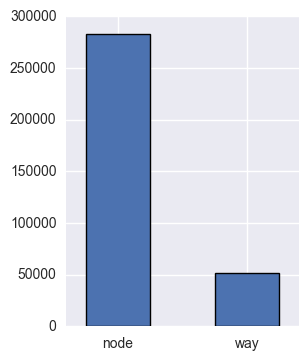

In [12]:
## How many nodes and ways do we have within this dataset?
result=db.elements.aggregate([
    {"$match" : {"$or" : [{"type" : "node"},{"type" : "way"}]}},
    {"$group" : {"_id" : "$type",
                 "count" : {"$sum" : 1}}},
    {"$sort" : {"count" : -1}}
])
values = []
keys = ['node', 'way']
for r in result:
    values.append(r['count'])
    pprint.pprint(r)

fig = plt.gcf()
fig.set_size_inches(3, 4)
    
plt.bar(left=range(2),height=values,align='center',width=0.5,linewidth=1,tick_label='teste')
plt.xticks(range(2), keys)
plt.show()

In [13]:
## How many establishments are open all days of the week?
result=db.elements.find({"opening_hours" : {"$exists" : 1}
                         ,"opening_hours.Sun" : {"$ne" : []}
                         ,"opening_hours.Mon" : {"$ne" : []}
                         ,"opening_hours.Tue" : {"$ne" : []}
                         ,"opening_hours.Wed" : {"$ne" : []}
                         ,"opening_hours.Thu" : {"$ne" : []}
                         ,"opening_hours.Fri" : {"$ne" : []}
                         ,"opening_hours.Sat" : {"$ne" : []}
                        }).count()
print "%i Establishments\n" % result

result=db.elements.find({"opening_hours" : {"$exists" : 1}
                         ,"opening_hours.Sun" : {"$ne" : []}
                         ,"opening_hours.Mon" : {"$ne" : []}
                         ,"opening_hours.Tue" : {"$ne" : []}
                         ,"opening_hours.Wed" : {"$ne" : []}
                         ,"opening_hours.Thu" : {"$ne" : []}
                         ,"opening_hours.Fri" : {"$ne" : []}
                         ,"opening_hours.Sat" : {"$ne" : []}
                        }
                        ,{"name" : 1
                         ,"amenity" : 1
                         ,"shop" : 1
                         ,"_id" : 0}
                       ).limit(10)
for r in result:
    pprint.pprint(r)

109 Establishments

{u'name': u'Mercadorama', u'shop': u'supermarket'}
{u'amenity': u'fuel', u'name': u'Posto O Cupim 2', u'shop': u'kiosk'}
{u'amenity': u'fuel', u'shop': u'kiosk'}
{u'amenity': u'pharmacy', u'name': u'FarmaTotal'}
{u'amenity': u'atm'}
{u'name': u'Engenho do P\xe3o', u'shop': u'bakery'}
{u'name': u'Sempre Mais', u'shop': u'supermarket'}
{u'amenity': u'post_office', u'name': u'ACF Rui Barbosa'}
{u'name': u'Cicles Carneiro', u'shop': u'sports'}
{u'amenity': u'pharmacy', u'name': u'Farmacia FarmaTotal'}


In [14]:
## How many restaurants do we have for each city?
result=db.elements.aggregate([
    {"$match" : {"amenity" : {"$in" : ["restaurant","fast_food"]}}},
    {"$group" : {"_id" : "$address.city",
                 "count" : {"$sum" : 1}}},
    {"$sort" : {"count" : -1}}
])
# result=db.elements.find({"recycling" : 1})
for r in result:
    pprint.pprint(r)

{u'_id': None, u'count': 358}
{u'_id': u'Curitiba', u'count': 76}
{u'_id': u'Batel', u'count': 3}
{u'_id': u'S\xe3o Jos\xe9 dos Pinhais', u'count': 3}
{u'_id': u'Arauc\xe1ria', u'count': 2}


In [15]:
# How many establishments has wifi access?
result=db.elements.find({"wifi" : "yes"}).count()
print "%i establishments" % result

4 establishments


---
### Conclusions
---
Analysing and cleaning this dataset is a very long and tough process. Since we have a lot of ways to deal with the data and to organize it, we have to decide which kind of information we would like to extract from it once we have it stored in the database.
However, after loading the data into the database and making some queries over the dataset, we can realize that this data will not give us reliable awnswers to our questions.
For instance, if we try to get how many establishments are open during the weekend to each city, we would have the following answer:

In [16]:
result=db.elements.aggregate([
    {"$match" : {"opening_hours" : {"$exists" : 1}
                ,"opening_hours.Sat" : {"$ne" : []}
                ,"opening_hours.Sun" : {"$ne" : []}}},
    {"$group" : {"_id" : "$address.city",
                 "count" : {"$sum" : 1}}},
    {"$sort" : {"count" : -1}}
])
for r in result:
    pprint.pprint(r)

{u'_id': None, u'count': 68}
{u'_id': u'Curitiba', u'count': 49}
{u'_id': u'S\xe3o Jos\xe9 dos Pinhais', u'count': 5}
{u'_id': u'Pinhais', u'count': 1}


---
The first thing to take into account is that most of the establishments have no city associated to them. Besides that, the numbers that we have to the third and forth cities are too low, so it is probably not real numbers. And the most important part:

---

In [17]:
cnt=len(db.elements.distinct("address.city"))
print "%i Cities\n" % cnt
result=db.elements.distinct("address.city")
for r in result:
    pprint.pprint(r)

15 Cities

u'Curitiba'
u'S\xe3o Jos\xe9 dos Pinhais'
u'Arauc\xe1ria'
u'Jardim Am\xe9lia - Pinhais'
u'Fanny'
u'Campo Largo'
u'Tarum\xe3'
u'Almirante Tamandar\xe9'
u'Pinhais'
u'Batel'
u'Alto da Rua XV'
u'Rebou\xe7as'
u'Cajuru'
u'Colombo'
u'Rio Verde'


---
We have **15 cities** in this dataset and **only 4** appeared in the previous query for the establishments openned during the weekend. This kind of result show us that we have a lot of missing data and for this reason we cannot develop reliable statistics over this dataset.
To this kind of dataset present more reliable data, we would need more interaction of users to fill those gaps.

#### How To Improve?
One thing that would help a lot for future uses of this data would be to **define some restrictions to the users** when they are putting new registries in the dataset. For instance, if the users had to follow some standards to put new data on the dataset, things would become a lot easier to maintain and to perform queries over it. One of the struggles that I have had over this dataset was to deal with the *opening_hours* element, and that is only because users could store this information in any kind of format.

---
### References
---
- **OSM XML**: https://wiki.openstreetmap.org/wiki/OSM_XML
- **Python - Regular Expression Operation Documentation:** https://docs.python.org/2/library/re.html
- **MongoDB - Query Documents:** https://docs.mongodb.com/manual/tutorial/query-documents/